# __Lock in Amplifier Using EXPEYES__

### Importing the Libraries

In [1]:
import eyes17.eyes
import numpy as np
import math as m
import time
from scipy.fft import fft, ifft,fftfreq, fftshift
from tqdm import tqdm
import matplotlib.pyplot as plt

p=eyes17.eyes.open()

W###################-------------


### Defining the Frequencies and Amplitude of the Input Signal

In [34]:
# function generator settings
f = 1000 #Hz
amp = 2 #V

# expeyes17 settings
N_sample = 8192
N_div=64
t_gap = (1/(f*N_div))*10**6 #us

# experimental settings
warmup = True
triggering = False
right_clip = False

In [35]:
print(f"f = {f} Hz")
print(f"amp = {amp} V")
print(f"N_sample = {N_sample}")
print(f"N_div = {N_div}")
print(f"t_gap = {t_gap} us")


f = 1000 Hz
amp = 2 V
N_sample = 8192
N_div = 64
t_gap = 15.625 us


### Setting the Input Signal as a sine wave of frequency 1000Hz

In [36]:
warmup_values = [100,500,1000,2000,4000]
for val in range(4500,8001,500):
    warmup_values.append(val)
for val in [8100,8190,8192]:
    warmup_values.append(val)

def warmup_expeyes(t_gap,warmup_values):
    for val in tqdm(warmup_values):
        t,v, tt,vv = p.capture2(val, t_gap)

In [37]:
if warmup: warmup_expeyes(t_gap,warmup_values)

100%|██████████| 16/16 [00:06<00:00,  2.45it/s]


In [38]:
t,v, tt,vv = p.capture2(N_sample, t_gap)

In [39]:
print(f"t_gap = {t_gap} us")
print(f"N_sample = {N_sample}")

print(f"len(t) = {len(t)}")

t_gap = 15.625 us
N_sample = 8192
len(t) = 5000


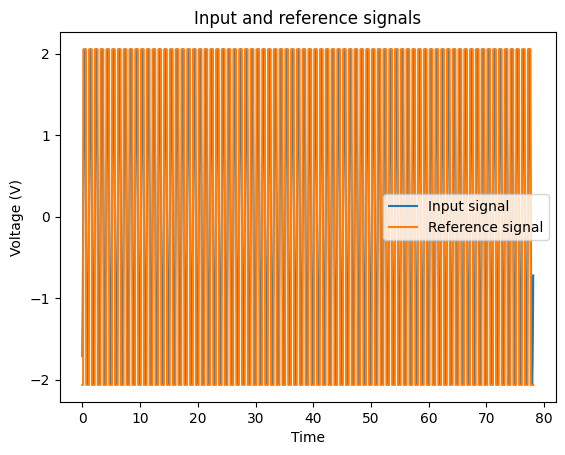

length of input signal = 5000


In [40]:
plt.plot(t,v, label='Input signal')
plt.plot(tt,vv, label='Reference signal')
plt.xlabel('Time')
plt.ylabel('Voltage (V)')
plt.title('Input and reference signals')
plt.legend()
plt.show()
print(f"length of input signal = {len(v)}")

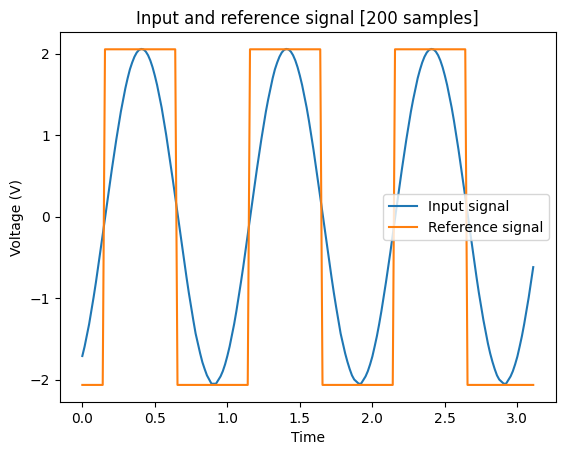

In [41]:
plt.plot(t[:200],v[:200], label='Input signal')
plt.plot(tt[:200],vv[:200], label='Reference signal')
plt.xlabel('Time')
plt.ylabel('Voltage (V)')
plt.title('Input and reference signal [200 samples]')
plt.legend()
plt.show()

### Generating the Reference Signals (Sine and Cosine)

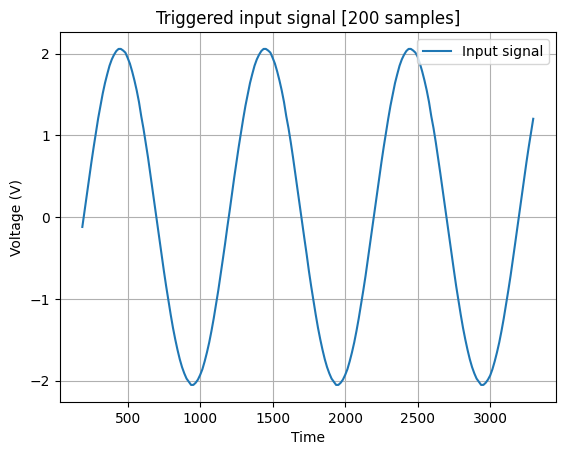

In [42]:
# trigger the reference signal vv by rising edge
def trigger(vv):
    for i in range(len(vv)-1):
        if vv[i] < 0 and vv[i+1] > 0:
            return i + 1
    return i

if triggering:
    trigger_index = trigger(vv)
    print(f"Trigger index = {trigger_index}")

    triggered_t = t[trigger_index:]
    triggered_v = v[trigger_index:]
    triggered_vv = vv[trigger_index:]

def right_clip_trigger(triggered_vv):

    right_clip_index = len(triggered_vv) - 1
    for i in range(right_clip_index, 0, -1):
        if triggered_vv[i] > 0 and triggered_vv[i-1] < 0:
            return i - 1
    return i

if right_clip:
    right_clip_index = right_clip_trigger(triggered_vv)
    print(f"Right clip index = {right_clip_index}")

    triggered_t = triggered_t[:right_clip_index]
    triggered_v = triggered_v[:right_clip_index]
    triggered_vv = triggered_vv[:right_clip_index]

# plotting the triggered input signal
cutoff = 200
plt.plot(triggered_t[:cutoff]*1000,triggered_v[:cutoff], label='Input signal')
plt.xlabel('Time')
plt.ylabel('Voltage (V)')
plt.title(f'Triggered input signal [{cutoff} samples]')
plt.grid()
plt.legend()
plt.show()

In [43]:
V_sin_ref=[]
V_cos_ref=[]
t_ref = []

curr_N_sample = len(triggered_v)
for i in range(curr_N_sample):
    V_sin_ref.append(amp*m.sin(2*m.pi*f*i*t_gap*10**-6))
    V_cos_ref.append(amp*m.cos(2*m.pi*f*i*t_gap*10**-6))
    t_ref.append(i*t_gap)

print(len(V_sin_ref))    


4928


### Plotting the Reference and the input signals

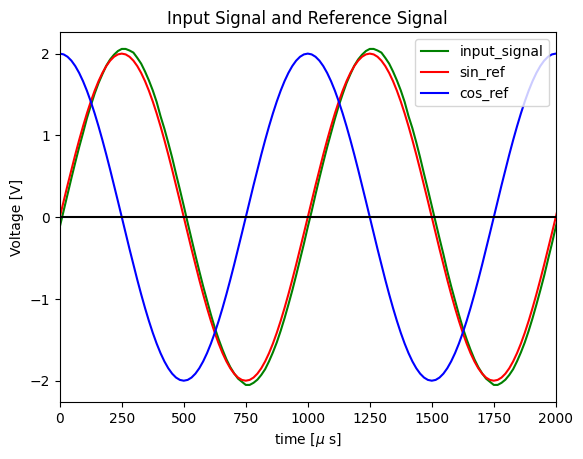

In [44]:
import matplotlib.pyplot as plt
plt.plot(t_ref,triggered_v,color='green',label='input_signal')
plt.plot(t_ref,V_sin_ref,color='red',label='sin_ref')
plt.plot(t_ref,V_cos_ref,color='blue',label='cos_ref')
plt.xlabel(r'time [$\mu $ s]')
plt.ylabel('Voltage [V]')
plt.xlim(0,2000)
plt.legend()
plt.title('Input Signal and Reference Signal')
plt.axhline(y=0, c="black")
plt.show()

### Phase matching (Multipling the input with sin)

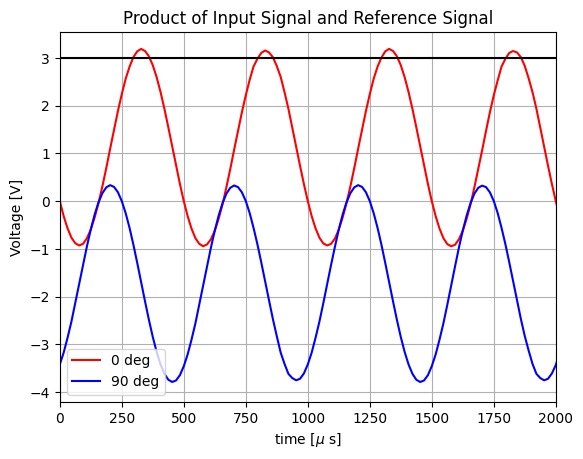

In [45]:
v_pm_sin = []
v_pm_cos = []
for i in range(curr_N_sample):
    v_pm_sin.append(v[i]*V_sin_ref[i])
    v_pm_cos.append(v[i]*V_cos_ref[i])

import matplotlib.pyplot as plt_pm
plt_pm.plot(t_ref,v_pm_sin,color='red',label='0 deg')
plt_pm.plot(t_ref,v_pm_cos,color='blue',label='90 deg')
plt_pm.xlabel(r'time [$\mu $ s]')
plt_pm.title('Product of Input Signal and Reference Signal')
plt_pm.ylabel('Voltage [V]')
plt_pm.xlim(0,2000)
plt_pm.legend()
plt_pm.axhline(y=3, c="black")
plt.grid()
plt_pm.show()


### Taking FFT for Low Pass Filter

In [46]:
freq=fftfreq(curr_N_sample,(t[1]-t[0])*0.001)
sine_fft=fft(v_pm_sin)
cos_fft=fft(v_pm_cos)

### Plotting the Sine wave in the frequency domain

c:\Users\Dell\Desktop\adhil-anagha_expeyes\Lockin_expeyes\.venv\Lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\Dell\Desktop\adhil-anagha_expeyes\Lockin_expeyes\.venv\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


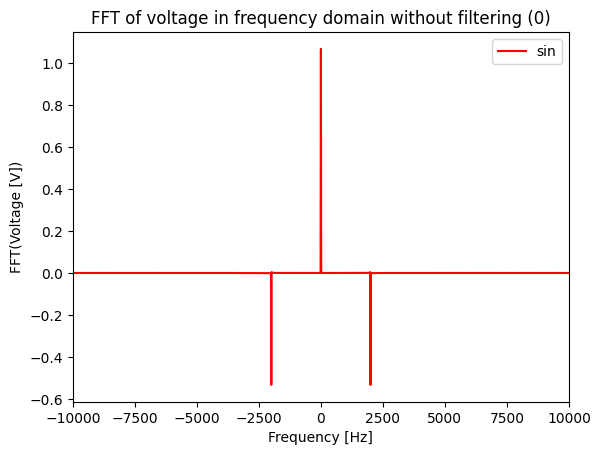

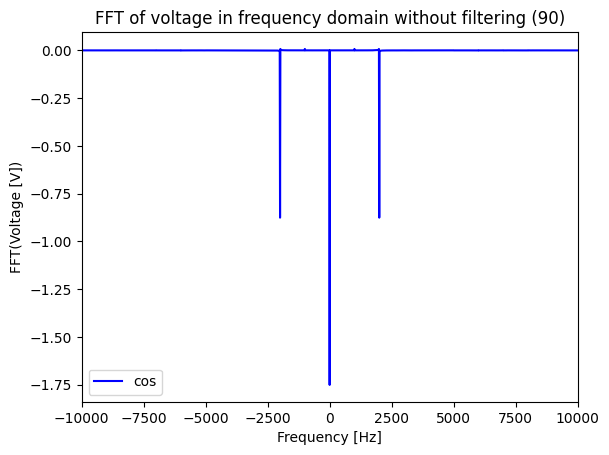

In [47]:
xf = fftshift(freq)
yplot = (1/curr_N_sample) * fftshift(sine_fft)


import matplotlib.pyplot as plt_fft
plt_fft.plot(xf,(yplot),color='red',label='sin')
plt_fft.xlabel(r'Frequency [Hz]')
plt_fft.ylabel('FFT(Voltage [V])')
plt_fft.title('FFT of voltage in frequency domain without filtering (0)')
plt_fft.xlim(-10000,10000)
plt_fft.legend()
plt_fft.show()

yplot = (1/curr_N_sample) * fftshift(cos_fft)

import matplotlib.pyplot as plt_fft
plt_fft.plot(xf,(yplot),color='blue',label='cos')
plt_fft.xlabel(r'Frequency [Hz]')
plt_fft.ylabel('FFT(Voltage [V])')
plt_fft.title('FFT of voltage in frequency domain without filtering (90)')
plt_fft.xlim(-10000,10000)
plt_fft.legend()
plt_fft.show()


### Calculating the Voltages

In [48]:
print("X component of the output Voltage",sine_fft[0].real/len(sine_fft))
print("Y component of the Output Voltage",cos_fft[0].real/len(cos_fft))
print("Voltage is",np.sqrt((sine_fft[0].real/len(sine_fft))**2+(cos_fft[0].real/len(cos_fft))**2),"V")

print("Phase of the output Voltage",m.atan((cos_fft[0].real/len(cos_fft))/(sine_fft[0].real/len(sine_fft)))*180/m.pi,"deg")

X component of the output Voltage 1.0681816636680852
Y component of the Output Voltage -1.7510220021109533
Voltage is 2.0511192355573504 V
Phase of the output Voltage -58.61542002131368 deg


# Single run

In [73]:
# import libraries

import eyes17.eyes
import numpy as np
import math as m
import time
from scipy.fft import fft, ifft,fftfreq, fftshift
import matplotlib.pyplot as plt

p=eyes17.eyes.open()

# required functions

def warmup_expeyes(t_gap):
    warmup_values = []
    # warmup_values = [100,500,1000,2000,4000]
    for val in range(4500,8001,500):
        warmup_values.append(val)
    for val in [8100,8190,8192]:
        warmup_values.append(val)
    for val in warmup_values:
        t,v, tt,vv = p.capture2(val, t_gap)


# function generator settings

# function generator settings
f = 1000 #Hz
amp = 2 #V

# expeyes17 settings
N_sample = 8192
N_div=64
t_gap = (1/(f*N_div))*10**6 #us

worst_case_frequency_limits = [0,1]

worst_case_frequency_limits[0] = 1 / (1000e-6 * N_div)
worst_case_frequency_limits[1] = 1 / (2e-6 * N_div)

print(f"Current frequency limits = {worst_case_frequency_limits}")

# experimental settings
warmup = True
warmup_repititive = False
triggering = True
right_clip = True

auto_freq = True
freq_method = 'fft' # 'fft' or 'zero_crossing'

plot = True
plot_cutoff = 1

# internal settings dont touch!
warmup_flag = 0

print("settings ready!")

W###################-------------
Current frequency limits = [7.8125, 3906.25]
settings ready!


Auto detected frequency = 998.4000000000001 Hz
4927


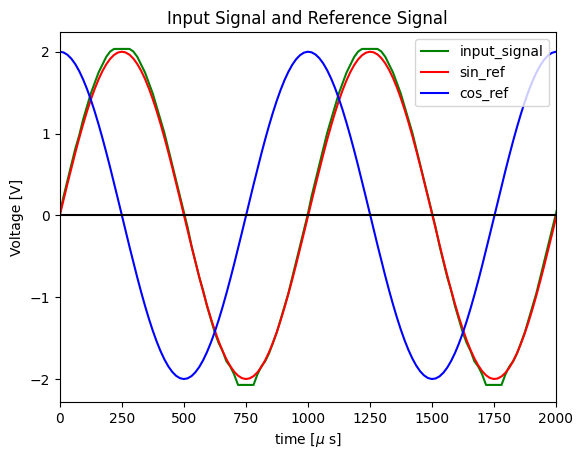

X component of the output Voltage -1.7417749682701227
Y component of the Output Voltage 1.010598087542669
Voltage is 2.013725039482125 V
Phase of the output Voltage 2.6158505188372168


In [68]:
if warmup and warmup_flag == 0: 
    if warmup_repititive: print("Performing repititive warmup...")
    else: print("Performing a warmup run.. coz the Expeyes misbehaving otherwise!")
        
    warmup_expeyes(t_gap)
    warmup_flag = 1
elif not warmup:
    print("NO WARMuP.. POSSIBLE FAILURE OF CAPTURE2...")
t,v, tt,vv = p.capture2(N_sample, t_gap)

v= np.array(v)
vv = np.array(vv)

# if plot:
#     cutoff_index = int(len(v) * plot_cutoff)
#     plt.plot(v[:cutoff_index])
#     plt.plot(vv[:cutoff_index])
#     plt.show()

# trigger the reference signal vv by rising edge
def trigger(vv):
    for i in range(len(vv)-1):
        if vv[i] < 0 and vv[i+1] > 0:
            return i + 1
    return i

if triggering:
    trigger_index = trigger(vv)
    # print(f"Trigger index = {trigger_index}")

    triggered_t = t[trigger_index:]
    triggered_v = v[trigger_index:]
    triggered_vv = vv[trigger_index:]
else:
    triggered_t = t
    triggered_v = v
    triggered_vv = vv

def right_clip_trigger(triggered_vv):

    right_clip_index = len(triggered_vv) - 1
    for i in range(right_clip_index, 0, -1):
        if triggered_vv[i] > 0 and triggered_vv[i-1] < 0:
            return i - 1
    return i

if right_clip:
    right_clip_index = right_clip_trigger(triggered_vv)
    # print(f"Right clip index = {right_clip_index}")

    triggered_t = triggered_t[:right_clip_index]
    triggered_v = triggered_v[:right_clip_index]
    triggered_vv = triggered_vv[:right_clip_index]

# # plotting the triggered input signal
# cutoff = 200
# plt.plot(triggered_t[:cutoff]*1000,triggered_v[:cutoff], label='Input signal')
# plt.xlabel('Time')
# plt.ylabel('Voltage (V)')
# plt.title(f'Triggered input signal [{cutoff} samples]')
# plt.grid()
# plt.legend()
# plt.show()

V_sin_ref=[]
V_cos_ref=[]
t_ref = []

if auto_freq:
    if freq_method == 'fft':
        freq=fftfreq(len(vv),(t[1]-t[0])*0.001)
        sine_fft=fft(vv)
        xf = fftshift(freq)
        yplot = (1/len(v)) * fftshift(sine_fft)

        # only positive frequencies
        xf2 = xf[xf>0]
        yplot2 = np.abs(yplot[xf>0])

        # plt.plot(xf2,(yplot2),color='red',label='sin')
        # plt.xlabel(r'Frequency [Hz]')
        # plt.ylabel('FFT(Voltage [V])')
        # plt.title('FFT of reference voltage in frequency domain')
        # # plt.xlim(0,10000)
        # plt.legend()
        # plt.show()

        # finding the max peak value
        peak_value = np.max(yplot2)

        # finding the first peak that is greater than 0.5 times the peak value

        peak_index = np.where(yplot2 > 0.8*peak_value)[0][0]

        freq = xf2[peak_index]

        
    elif freq_method == 'zero_crossing':
        zero_crossings = np.where(np.diff(np.sign(vv)))[0]
        freq = 1/(2*(t[zero_crossings[1]]-t[zero_crossings[0]]))
    
    print(f"Auto detected frequency = {freq} Hz")
else:
    freq = f


curr_N_sample = len(triggered_v)
for i in range(curr_N_sample):
    V_sin_ref.append(amp*m.sin(2*m.pi*freq*i*t_gap*10**-6))
    V_cos_ref.append(amp*m.cos(2*m.pi*freq*i*t_gap*10**-6))
    t_ref.append(i*t_gap)

print(len(V_sin_ref))    

plt.plot(t_ref,triggered_v,color='green',label='input_signal')
plt.plot(t_ref,V_sin_ref,color='red',label='sin_ref')
plt.plot(t_ref,V_cos_ref,color='blue',label='cos_ref')
plt.xlabel(r'time [$\mu $ s]')
plt.ylabel('Voltage [V]')
plt.xlim(0,2000)
plt.legend()
plt.title('Input Signal and Reference Signal')
plt.axhline(y=0, c="black")
plt.show()

v_pm_sin = []
v_pm_cos = []
for i in range(curr_N_sample):
    v_pm_sin.append(v[i]*V_sin_ref[i])
    v_pm_cos.append(v[i]*V_cos_ref[i])

# plt.plot(t_ref,v_pm_sin,color='red',label='0 deg')
# plt.plot(t_ref,v_pm_cos,color='blue',label='90 deg')
# plt.xlabel(r'time [$\mu $ s]')
# plt.title('Product of Input Signal and Reference Signal')
# plt.ylabel('Voltage [V]')
# plt.xlim(0,2000)
# plt.legend()
# plt.axhline(y=3, c="black")
# plt.grid()
# plt.show()

freq=fftfreq(curr_N_sample,(t[1]-t[0])*0.001)
sine_fft=fft(v_pm_sin)
cos_fft=fft(v_pm_cos)

xf = fftshift(freq)
yplot = (1/curr_N_sample) * fftshift(sine_fft)


# plt.plot(xf,(yplot),color='red',label='sin')
# plt.xlabel(r'Frequency [Hz]')
# plt.ylabel('FFT(Voltage [V])')
# plt.title('FFT of voltage in frequency domain without filtering (0)')
# plt.xlim(-10000,10000)
# plt.legend()
# plt.show()

yplot = (1/curr_N_sample) * fftshift(cos_fft)


# plt.plot(xf,(yplot),color='blue',label='cos')
# plt.xlabel(r'Frequency [Hz]')
# plt.ylabel('FFT(Voltage [V])')
# plt.title('FFT of voltage in frequency domain without filtering (90)')
# plt.xlim(-10000,10000)
# plt.legend()
# plt.show()

print("X component of the output Voltage",sine_fft[0].real/len(sine_fft))
print("Y component of the Output Voltage",cos_fft[0].real/len(cos_fft))
print("Voltage is",np.sqrt((sine_fft[0].real/len(sine_fft))**2+(cos_fft[0].real/len(cos_fft))**2),"V")
print("Phase of the output Voltage",np.arctan2((cos_fft[0].real/len(cos_fft)),(sine_fft[0].real/len(sine_fft))))